In [ ]:
"""
CSC240 Final Project

Name: Yuesong Huang
Collaborator: Junhua Huang, Boyang Wang, Yuyang Wang
E-mail: yhu116@u.rochester.edu, junhuahuang1218@gmail.com, bwang55@u.rochester.edu, ywang383@u.Rochester.edu
"""

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd
from pandas.plotting import table

import matplotlib.pyplot as plt
from matplotlib import colors

import seaborn as sns
from scipy import stats

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from xgboost import XGBClassifier


In [ ]:
# Load the dataset
df = pd.read_csv('./smoking_driking_dataset_Ver01.csv', engine='c')


In [ ]:
# Display basic information about the dataset
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991346 entries, 0 to 991345
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sex               991346 non-null  object 
 1   age               991346 non-null  int64  
 2   height            991346 non-null  int64  
 3   weight            991346 non-null  int64  
 4   waistline         991346 non-null  float64
 5   sight_left        991346 non-null  float64
 6   sight_right       991346 non-null  float64
 7   hear_left         991346 non-null  float64
 8   hear_right        991346 non-null  float64
 9   SBP               991346 non-null  float64
 10  DBP               991346 non-null  float64
 11  BLDS              991346 non-null  float64
 12  tot_chole         991346 non-null  float64
 13  HDL_chole         991346 non-null  float64
 14  LDL_chole         991346 non-null  float64
 15  triglyceride      991346 non-null  float64
 16  hemoglobin        99

# Data Transformation and Analysis


These code blocks are focused on transforming and analyzing categorical data within a dataframe, specifically related to smoking and drinking habits. The block defines three functions, each converting different categorical data (smoking status, drinking status, and gender) into numerical codes. These functions are then applied to the corresponding columns in the dataframe.



In [ ]:
def DRK_to_type_cd(yn):
  return 1 if yn == 'Y' else 0

def SMK_to_type_cd(n):
  if n == 3:
    return 2
  elif n == 2:
    return 1
  else:
    return 0

def sex_to_type_cd(sex):
  return 1 if sex == 'Male' else 0

df['DRK_stat_type_cd'] = df['DRK_YN'].apply(DRK_to_type_cd)
df['SMK_stat_type_cd'] = df['SMK_stat_type_cd'].apply(SMK_to_type_cd)
df['sex_type_cd'] = df['sex'].apply(sex_to_type_cd)


In [ ]:
non_smoker = len(df[df['SMK_stat_type_cd'] == 0]) / len(df) * 100
ex_smoker = len(df[df['SMK_stat_type_cd'] == 1]) / len(df) * 100
current_smoker = 100 - non_smoker - ex_smoker
print(f'Non-Smoker: {non_smoker}%')
print(f'Ex-Smoker: {ex_smoker}%')
print(f'Current Smoker: {current_smoker}%')

non_drinker = len(df[df['DRK_YN'] == 'N']) / len(df) * 100
drinker = 100 - non_drinker
print(f'Non-Drinker: {non_drinker}%')
print(f'Drinker: {drinker}%')


Non-Smoker: 60.77000361125178%
Ex-Smoker: 17.64782427124334%
Current Smoker: 21.58217211750488%
Non-Drinker: 50.0186614965915%
Drinker: 49.9813385034085%


# Visualizations, Descriptive Statistics, and Feature Engineering in Health Data


This extensive code block is dedicated to visualizing and analyzing various health metrics and lifestyle habits within a dataset. The block is structured into several parts, each focusing on different aspects of the data



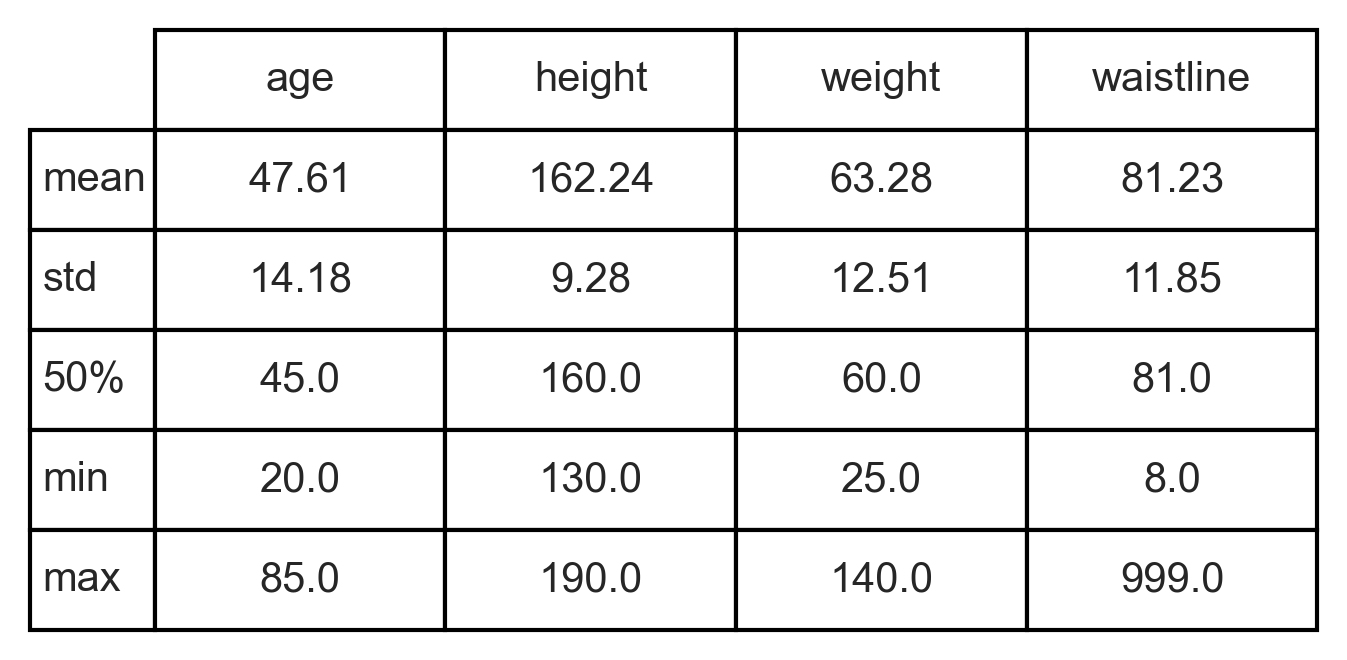

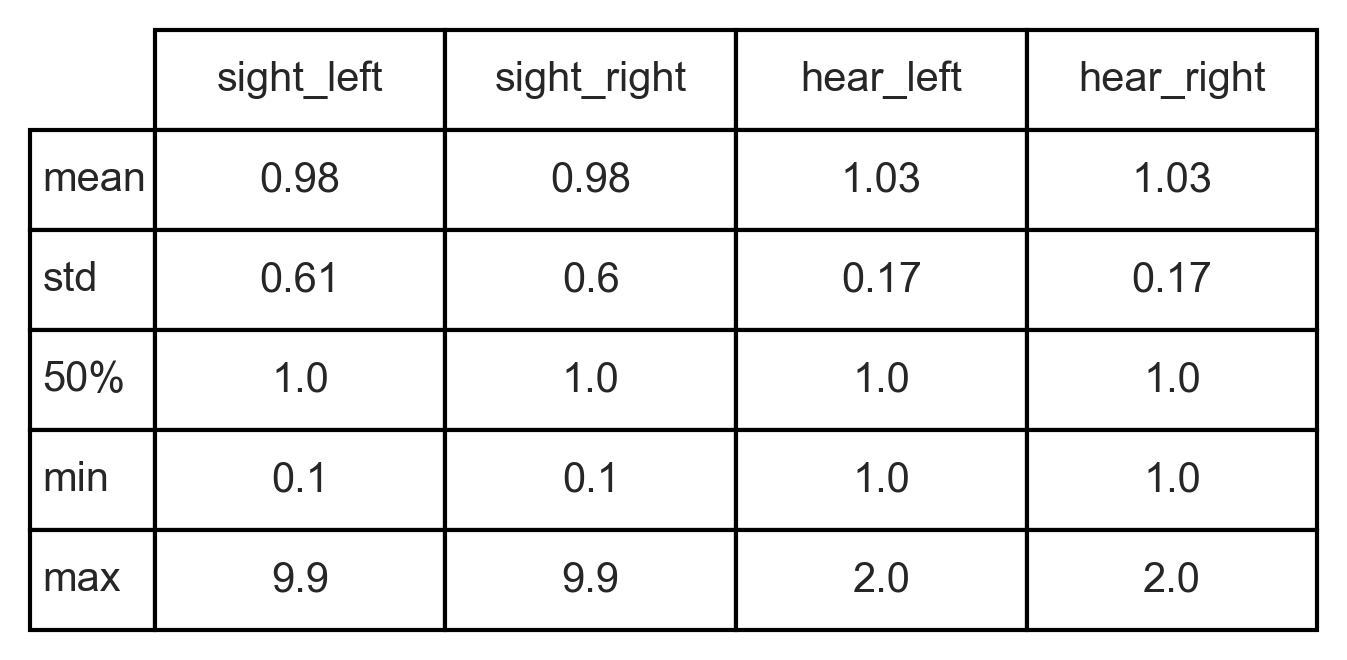

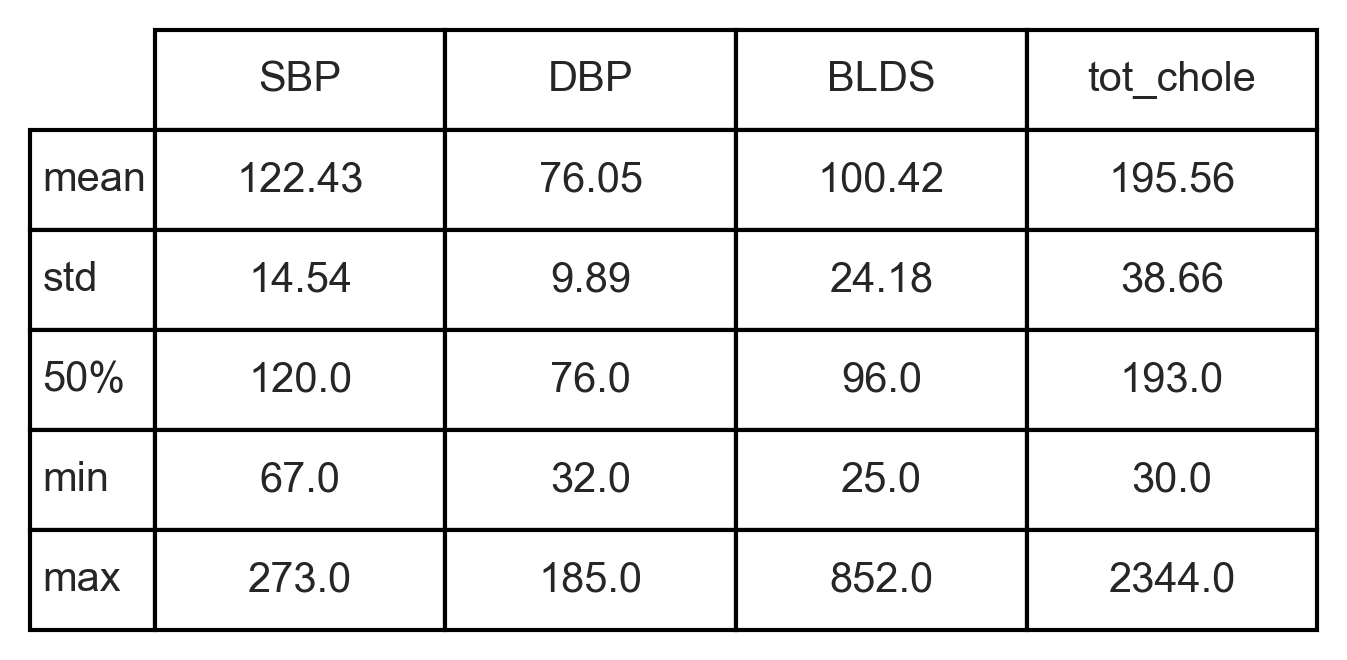

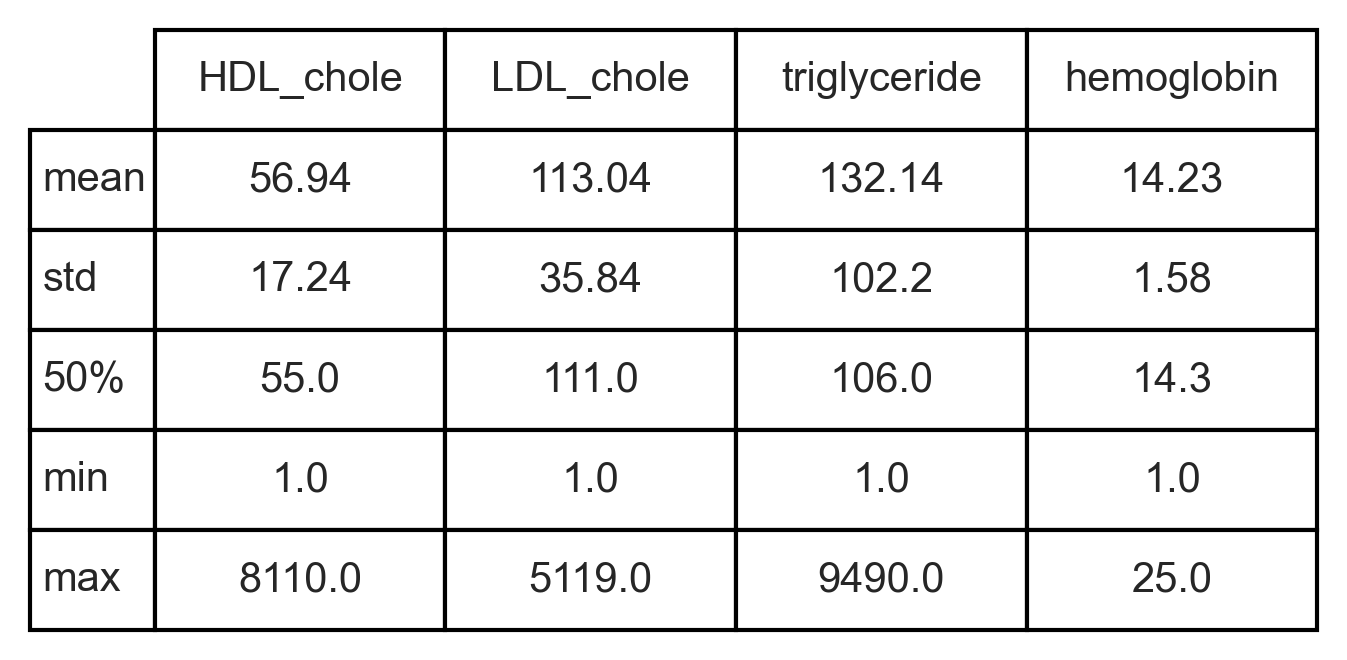

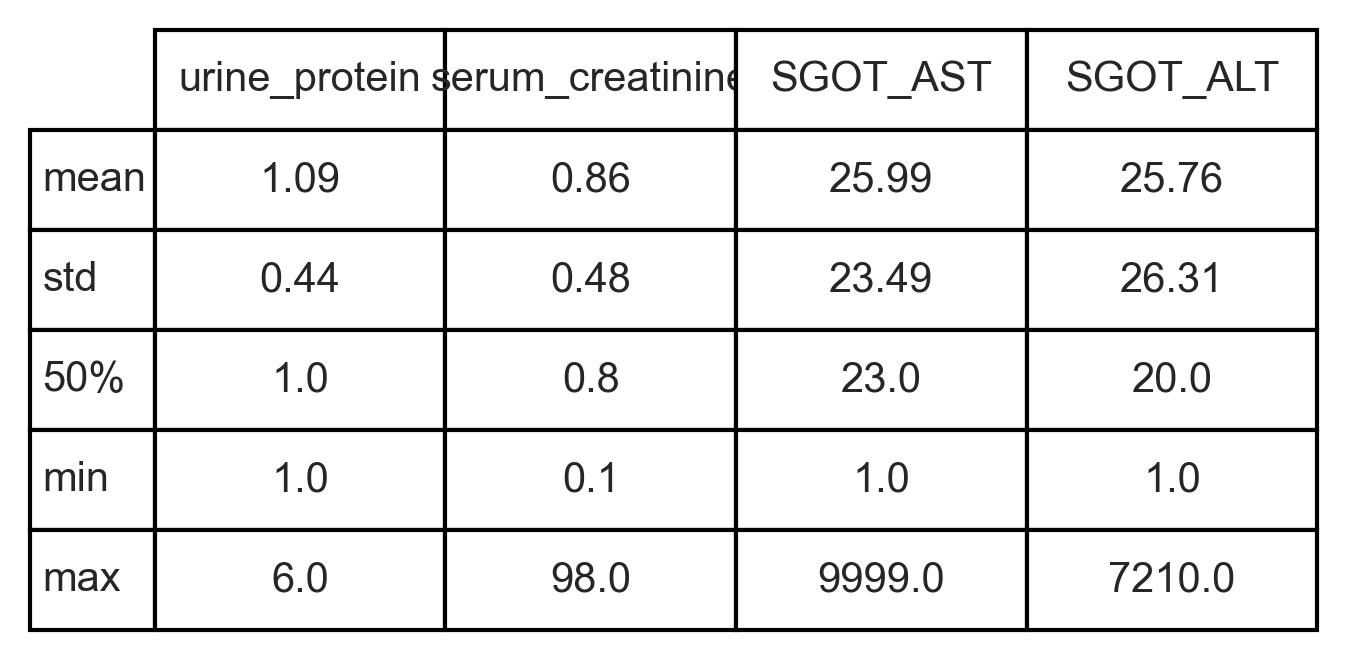

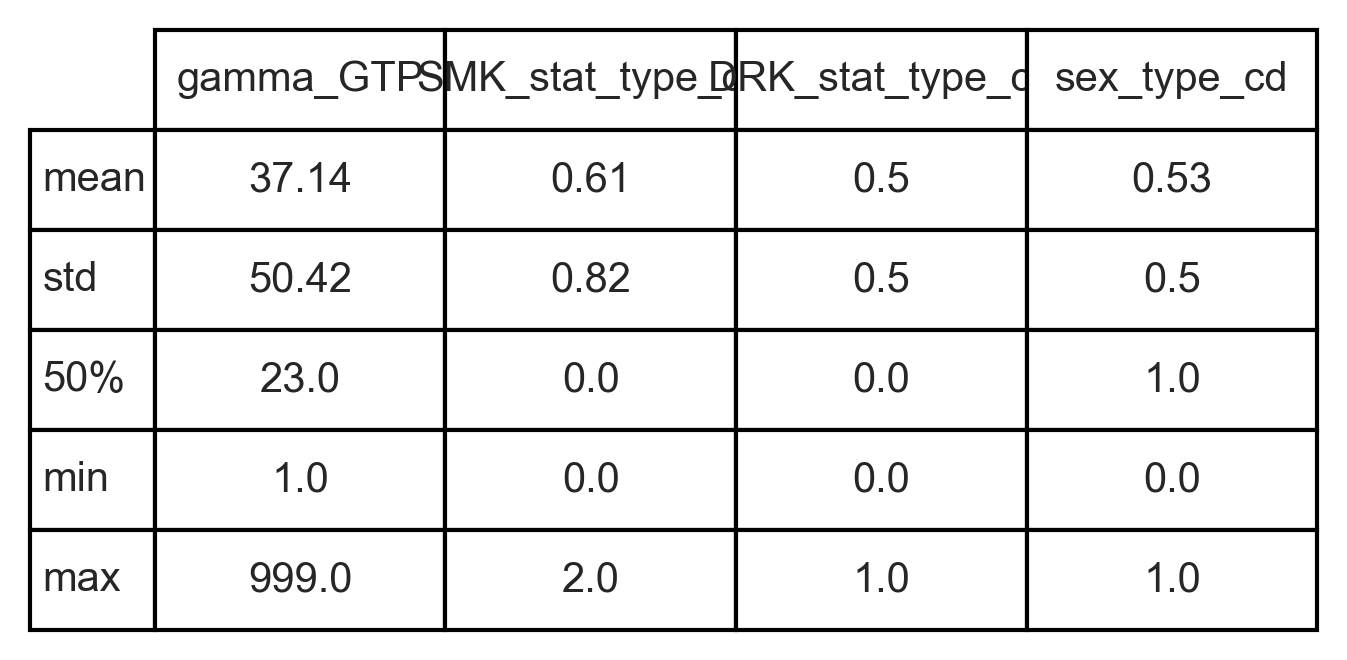

In [ ]:
required_stats = ['mean', 'std', '50%', 'min', 'max']
descr = df.describe().loc[required_stats].round(2)

# The number of rows and columns in our table
n_rows, n_cols = descr.shape

# Calculate the number of figures needed (each figure will contain 4 attributes)
num_figures = n_cols // 4 + (n_cols % 4 > 0)

# Create a figure for each group of 4 attributes
for i in range(num_figures):
    # Select the columns for the current figure
    cols = descr.columns[i*4 : (i+1)*4]

    # If we are at the last set and have fewer than 4, we break the loop
    if len(cols) == 0:
        break

    # Create a matplotlib figure
    fig, ax = plt.subplots(figsize=(5, 2), dpi=300)

    # Add the subset of descriptive statistics to the figure
    the_table = table(ax, descr[cols], loc='center', cellLoc='center')

    # Set the fontsize of the cells in the table
    cell_text_size = 10
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(cell_text_size)
    the_table.scale(1, 2)  # Scale the table to fit the attributes

    # Hide the axes
    ax.axis('off')

    # Show the plot
    plt.show()


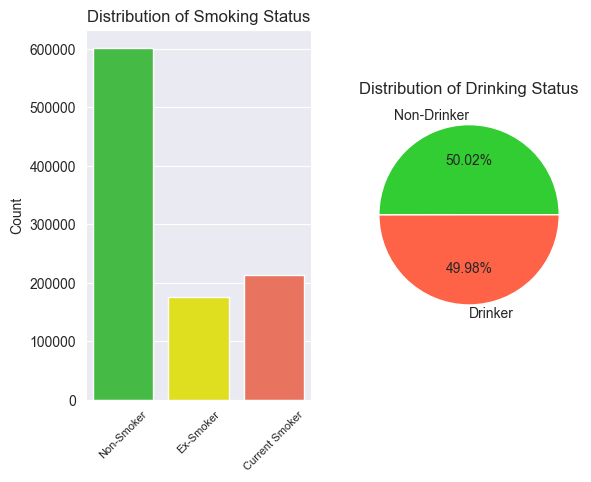

In [ ]:
# Create a simple data visualization
plt.figure()

plt.subplot(1, 2, 1)
sns.countplot(x='SMK_stat_type_cd', data=df, palette=['limegreen', 'yellow', 'tomato'])
plt.title('Distribution of Smoking Status')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks([0, 1, 2], ['Non-Smoker', 'Ex-Smoker', 'Current Smoker'], rotation=45, fontsize=8)

labels = ['Non-Drinker', 'Drinker']
values = [non_drinker, drinker]

# Pie chart
plt.subplot(1, 2, 2)
plt.pie(values, labels=labels, autopct='%1.2f%%', colors=['limegreen', 'tomato'])
plt.title('Distribution of Drinking Status')

plt.show()


In [ ]:
# Selecting relevant health metrics columns for correlation analysis
num_columns = ['sex_type_cd', 'age', 'height', 'weight', 'waistline', 'sight_left', 'sight_right', 'hear_left', 'hear_right', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin',
          'urine_protein', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'SMK_stat_type_cd', 'DRK_stat_type_cd']

correlation_matrix = df[num_columns].corr()

weak = []
medium = []
strong = []


# Iterate over the matrix
for i in range(len(correlation_matrix)):
  for j in range(i):
    value = correlation_matrix.iloc[i, j]

    # Classify the correlation value
    if abs(value) > 0.75:
      strong.append([correlation_matrix.index[i], correlation_matrix.index[j], 'Strong', value])
    elif 0.5 <= abs(value) <= 0.75:
      medium.append([correlation_matrix.index[i], correlation_matrix.index[j], 'Medium', value])
    else:
      weak.append([correlation_matrix.index[i], correlation_matrix.index[j], 'Weak', value])

# Print the observations
def print_observations(observations):
  if len(observations) == 0:
    print('N/A')
  else:
    for observation in observations:
      print(f'The correlation between {observation[0]} and {observation[1]} is {observation[2]} ({observation[3]:.6f}).')

print('\nStrong correlation observations:')
print_observations(strong)

print('\nMedium correlation observations:')
print_observations(medium)



Strong correlation observations:
The correlation between LDL_chole and tot_chole is Strong (0.877367).

Medium correlation observations:
The correlation between height and sex_type_cd is Medium (0.722774).
The correlation between weight and sex_type_cd is Medium (0.581707).
The correlation between weight and height is Medium (0.668823).
The correlation between waistline and weight is Medium (0.637173).
The correlation between hear_right and hear_left is Medium (0.536890).
The correlation between DBP and SBP is Medium (0.741131).
The correlation between hemoglobin and sex_type_cd is Medium (0.669417).
The correlation between hemoglobin and height is Medium (0.531898).
The correlation between SGOT_ALT and SGOT_AST is Medium (0.641722).
The correlation between SMK_stat_type_cd and sex_type_cd is Medium (0.591004).


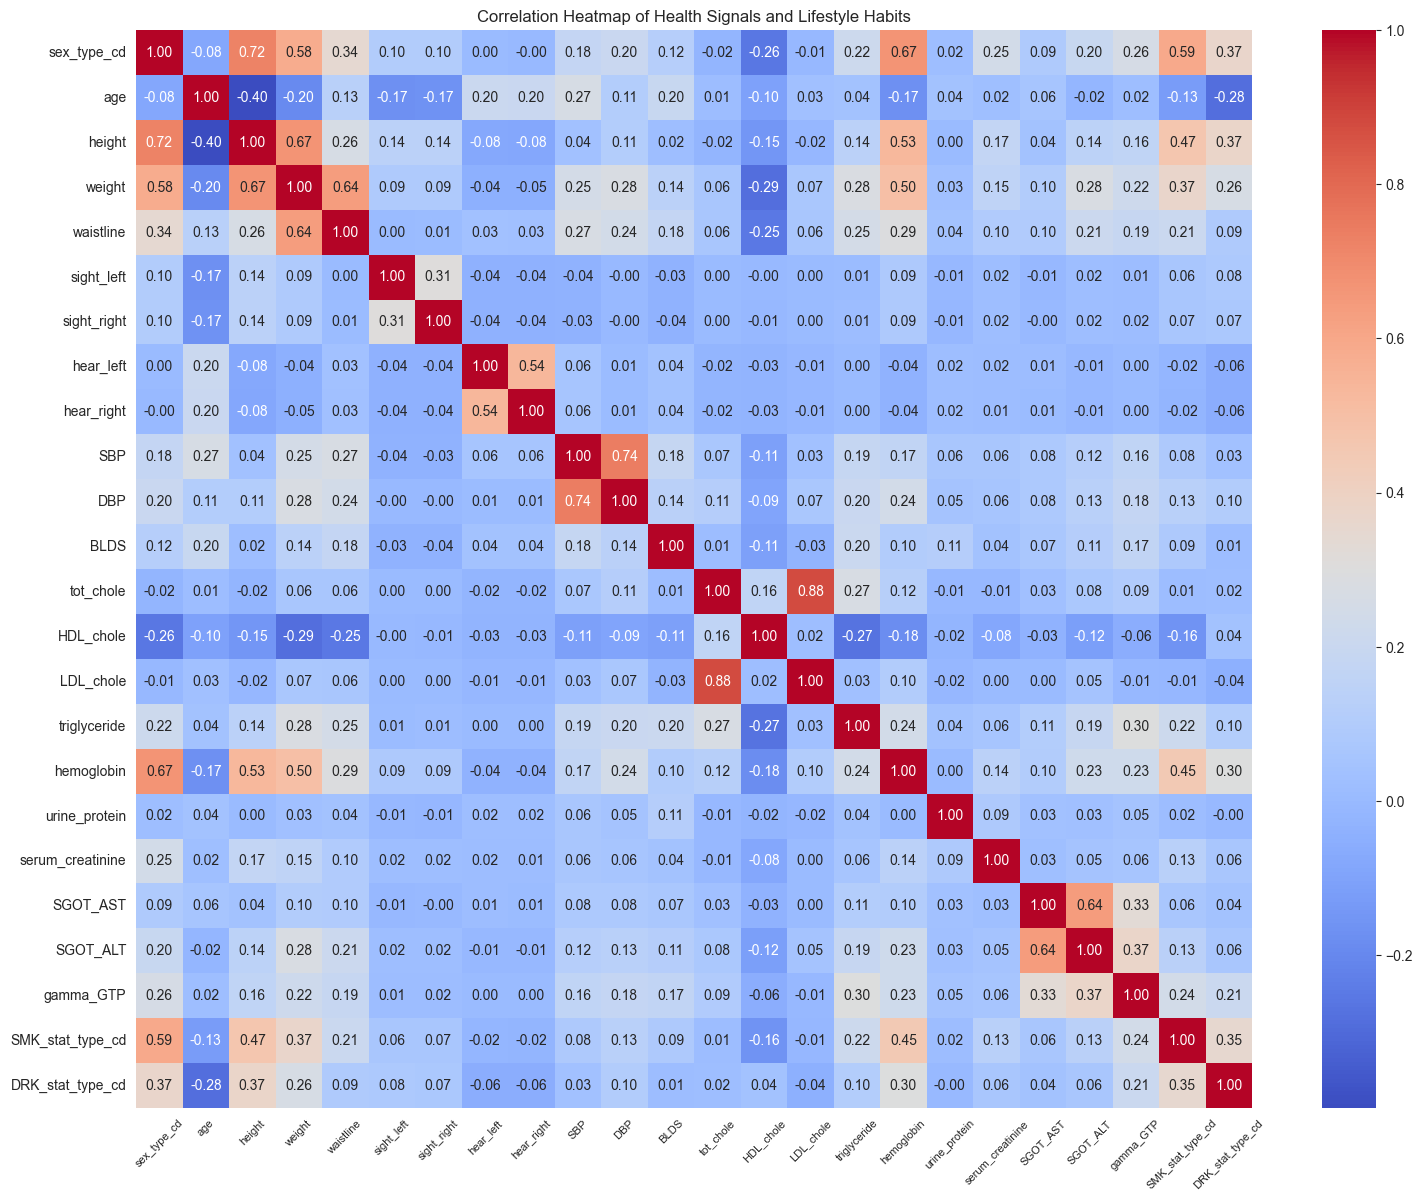

In [ ]:
plt.figure(figsize=(18, 14))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Health Signals and Lifestyle Habits')
plt.xticks(rotation=45, fontsize=8)
plt.show()


In [ ]:
frequency_columns = ['sex_type_cd', 'age', 'height', 'weight', 'waistline', 'sight_left', 'sight_right', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin',
          'urine_protein', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'SMK_stat_type_cd', 'DRK_stat_type_cd']

# Initialize encoder
encoder = TransactionEncoder()

# Convert your DataFrame to a list of lists
transactions = []
for row in df[frequency_columns].values.tolist():
  transaction = []
  for i, column in enumerate(frequency_columns):
    transaction.append(f'{column}={row[i]}')
  transactions.append(transaction)


In [ ]:
# Fit and transform
frequency = encoder.fit(transactions).transform(transactions)

# Convert back to DataFrame
df_frequency = pd.DataFrame(frequency, columns=encoder.columns_)

# Using the apriori algorithm to find frequent itemsets and sort
frequent_itemsets = apriori(df_frequency, min_support=0.2, use_colnames=True).sort_values(by='support', ascending=False)

# Displaying the top 5 and bottom 5 frequent itemsets
frequent_itemsets_top_10_most_1 = frequent_itemsets.head(10)
frequent_itemsets_top_10_least_1 = frequent_itemsets.tail(10)


In [ ]:
print('Top 10 most frequent itemsets with min_support=0.2:')

frequent_itemsets_top_10_most_1


Top 10 most frequent itemsets with min_support=0.2:


,support,itemsets
8,0.943339,(urine_protein=1.0)
2,0.607700,(SMK_stat_type_cd=0.0)
16,0.575224,"(urine_protein=1.0, SMK_stat_type_cd=0.0)"
5,0.531010,(sex_type_cd=1.0)
0,0.500187,(DRK_stat_type_cd=0.0)
1,0.499813,(DRK_stat_type_cd=1.0)
19,0.498956,"(sex_type_cd=1.0, urine_protein=1.0)"
11,0.472472,"(urine_protein=1.0, DRK_stat_type_cd=0.0)"
14,0.470867,"(urine_protein=1.0, DRK_stat_type_cd=1.0)"
4,0.468990,(sex_type_cd=0.0)


In [ ]:
print('Top 10 least frequent itemsets with min_support=0.2:')

frequent_itemsets_top_10_least_1


Top 10 least frequent itemsets with min_support=0.2:


,support,itemsets
10,0.326586,"(DRK_stat_type_cd=0.0, sex_type_cd=0.0)"
20,0.315914,"(SMK_stat_type_cd=0.0, DRK_stat_type_cd=0.0, s..."
22,0.309762,"(urine_protein=1.0, DRK_stat_type_cd=0.0, sex_..."
26,0.299769,"(urine_protein=1.0, DRK_stat_type_cd=0.0, SMK_..."
3,0.215822,(SMK_stat_type_cd=2.0)
12,0.215294,"(SMK_stat_type_cd=0.0, DRK_stat_type_cd=1.0)"
7,0.206278,(sight_right=1.0)
23,0.203424,"(urine_protein=1.0, SMK_stat_type_cd=0.0, DRK_..."
6,0.203176,(sight_left=1.0)
17,0.202862,"(urine_protein=1.0, SMK_stat_type_cd=2.0)"


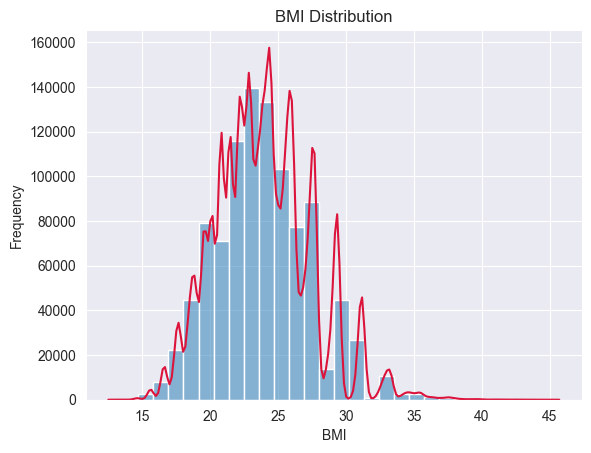

In [ ]:
#BMI
df['BMI'] = df['weight'] / (df['height'] / 100) ** 2

# BMI Distribution
plt.figure()
sns.histplot(df['BMI'], bins=30, kde=True).lines[0].set_color('crimson')
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()


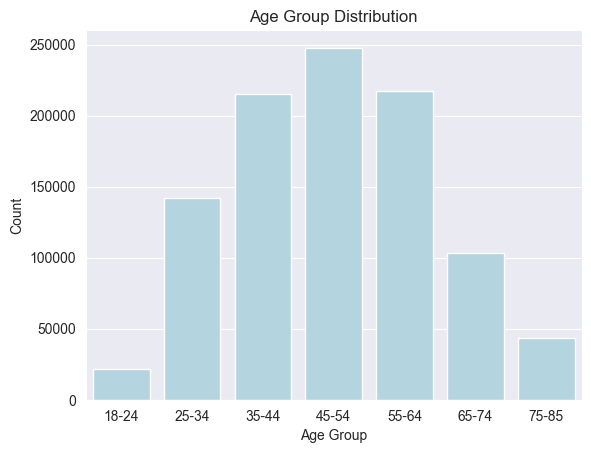

In [ ]:
bins = [18, 25, 35, 45, 55, 65, 75, 86]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-85']
df['Age_Group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Age Group Distribution
plt.figure()
sns.countplot(x='Age_Group', data=df, color='lightblue')
plt.title('Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()


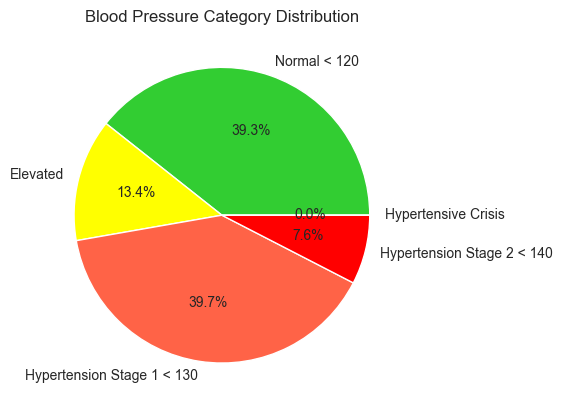

In [ ]:
def categorize_blood_pressure(col):
    if col['SBP'] < 120 and col['DBP'] < 80:
        return 0
    elif 120 <= col['SBP'] < 130 and col['DBP'] < 80:
        return 1
    elif 130 <= col['SBP'] < 140 or 80 <= col['DBP'] < 90:
        return 2
    elif col['SBP'] >= 140 or col['DBP'] >= 90:
        return 3
    else:
        return 4 # SBP > 180 and/or DBP > 120

df['BP_Category'] = df.apply(categorize_blood_pressure, axis=1)

BP_counts = df['BP_Category'].value_counts()
BP_counts = [BP_counts.get(0, 0), BP_counts.get(1, 0), BP_counts.get(2, 0), BP_counts.get(3, 0), BP_counts.get(4, 0)]

plt.figure()
plt.pie(BP_counts, labels=['Normal < 120', 'Elevated', 'Hypertension Stage 1 < 130', 'Hypertension Stage 2 < 140', 'Hypertensive Crisis'], autopct='%1.1f%%', colors=['limegreen', 'yellow', 'tomato', 'red', 'crimson'])
plt.title('Blood Pressure Category Distribution')
plt.show()


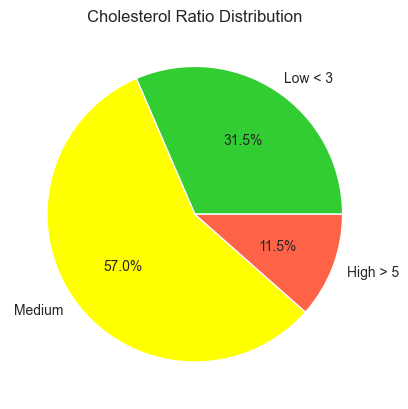

In [ ]:
# Example thresholds for categorization
low_threshold = 3  # Define the threshold for 'Low'
medium_threshold = 5  # Define the threshold for 'Medium'

# Function to categorize cholesterol ratio
def categorize_cholesterol_ratio(ratio):
    if ratio < low_threshold:
        return 0
    elif ratio < medium_threshold:
        return 1
    else:
        return 2

# Apply the categorization function to the DataFrame
df['chole_ratio'] = df['tot_chole'] / df['HDL_chole']
df['chole_category'] = df['chole_ratio'].apply(categorize_cholesterol_ratio)

# Count the number of entries in each category
chole_counts = df['chole_category'].value_counts()

# Extract counts for each category
chole_counts = [chole_counts.get(0, 0), chole_counts.get(1, 0), chole_counts.get(2, 0)]

plt.figure()
plt.pie(chole_counts, labels=['Low < 3', 'Medium', 'High > 5'], autopct='%1.1f%%', colors=['limegreen', 'yellow', 'tomato'])
plt.title('Cholesterol Ratio Distribution')
plt.show()


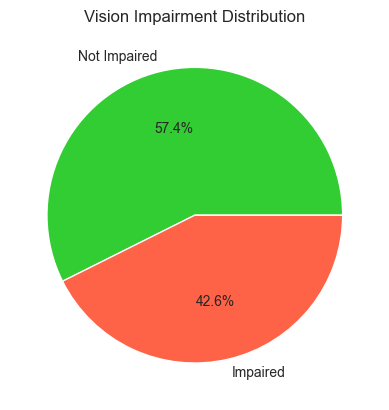

In [ ]:
vision_threshold = 1.0  # Example threshold, adjust as needed
df['sights_impaired'] = np.where(
    (df['sight_left'] < vision_threshold) | (df['sight_right'] < vision_threshold), 1, 0)

# Pie chart for Vision Impairment
sights_counts = df['sights_impaired'].value_counts()

plt.figure()
plt.pie(sights_counts, labels=['Not Impaired', 'Impaired'], autopct='%1.1f%%', colors=['limegreen', 'tomato'])
plt.title('Vision Impairment Distribution')
plt.show()


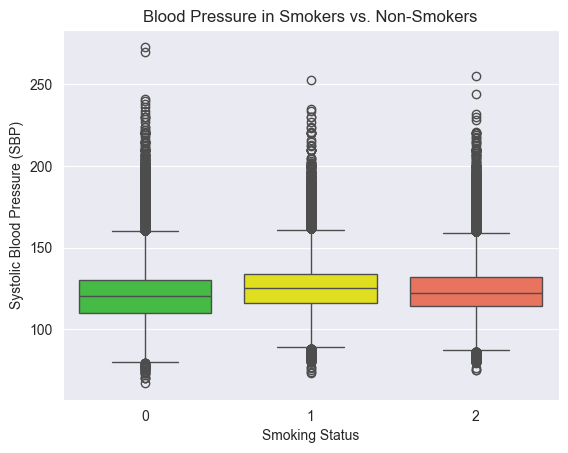

In [ ]:
# Visualization for Blood Pressure in Smokers vs. Non-Smokers
plt.figure()
sns.boxplot(x='SMK_stat_type_cd', y='SBP', data=df, palette=['limegreen', 'yellow', 'tomato'])
plt.title('Blood Pressure in Smokers vs. Non-Smokers')
plt.xlabel('Smoking Status')
plt.ylabel('Systolic Blood Pressure (SBP)')
plt.show()


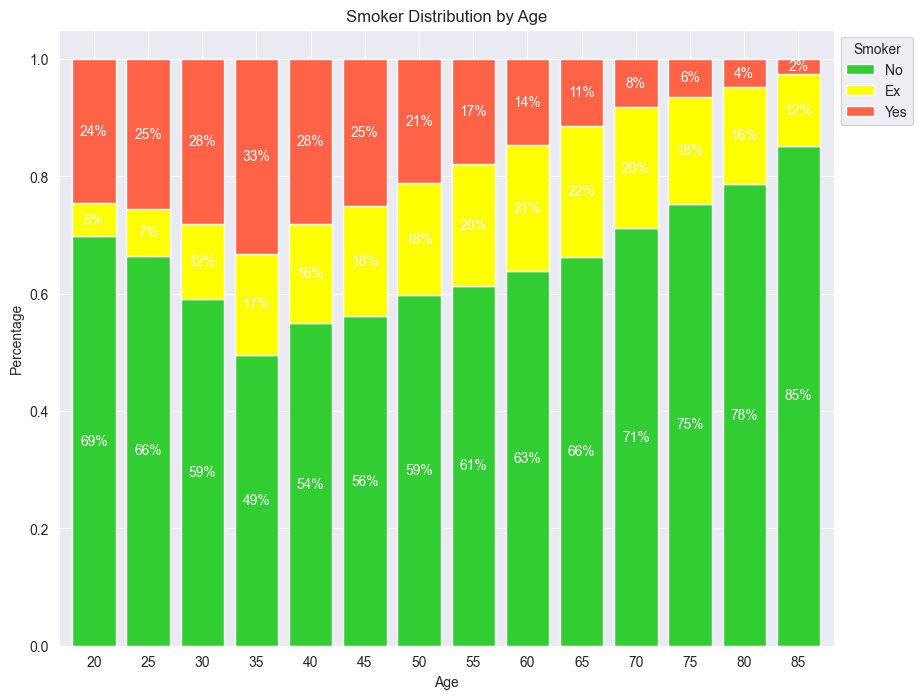

In [ ]:
df_by_age = df.groupby(['age', 'SMK_stat_type_cd']).size().unstack(fill_value=0)

# Normalizing the counts to get percentages
df_by_age_normalized = df_by_age.div(df_by_age.sum(axis=1), axis=0)

_, ax = plt.subplots(figsize=(10, 8))
df_by_age_normalized.plot(kind='bar', stacked=True, color=['limegreen', 'yellow', 'tomato'], width=0.8, ax=ax)
plt.title('Smoker Distribution by Age')
plt.xlabel('Age')
plt.ylabel('Percentage')
plt.xticks(rotation=0)

# Reversing the legend order to match the stack order
handles, labels = ax.get_legend_handles_labels()
ax.legend(labels=['No', 'Ex', 'Yes'], title='Smoker', loc='upper left', bbox_to_anchor=(1.0, 1.0))

# Add annotations for percentages
for x, y in enumerate([*df_by_age.index.values]):
  for (proportion, y_loc) in zip(df_by_age_normalized.loc[y], df_by_age_normalized.loc[y].cumsum()):
    ax.text(x=x, y=(y_loc - proportion) + (proportion / 2), s=f'{int(proportion * 100)}%',
      color="white", ha="center", va="center")

plt.show()


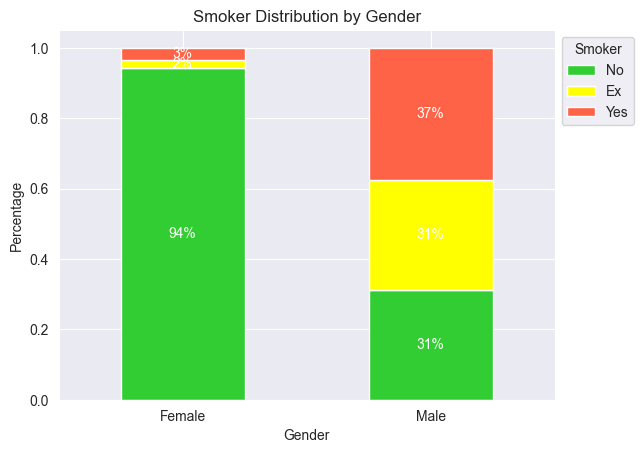

In [ ]:
df_by_smk = df.groupby(['sex', 'SMK_stat_type_cd']).size().unstack(fill_value=0)

# Normalizing the counts to get percentages
df_by_smk_normalized = df_by_smk.div(df_by_smk.sum(axis=1), axis=0)


ax = df_by_smk_normalized.plot(kind='bar', stacked=True, color=['limegreen', 'yellow', 'tomato'])
plt.title('Smoker Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.xticks(rotation=0)

# Reversing the legend order to match the stack order
handles, labels = ax.get_legend_handles_labels()
ax.legend(labels=['No', 'Ex', 'Yes'], title='Smoker', loc='upper left', bbox_to_anchor=(1.0, 1.0))

# Add annotations for percentages
for x, y in enumerate([*df_by_smk.index.values]):
  for (proportion, y_loc) in zip(df_by_smk_normalized.loc[y], df_by_smk_normalized.loc[y].cumsum()):
    ax.text(x=x, y=(y_loc - proportion) + (proportion / 2), s=f'{int(proportion * 100)}%',
      color="white", ha="center", va="center")

plt.show()


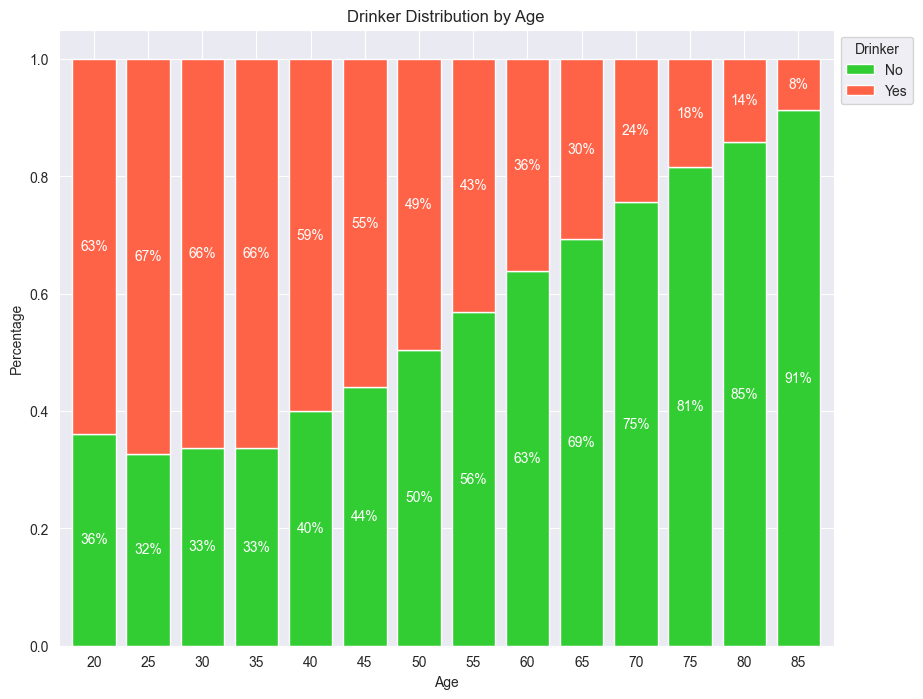

In [ ]:
df_by_age = df.groupby(['age', 'DRK_stat_type_cd']).size().unstack(fill_value=0)

df_by_age_normalized = df_by_age.div(df_by_age.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(10, 8))
df_by_age_normalized.plot(kind='bar', stacked=True, color=['limegreen', 'tomato'], width=0.8, ax=ax)
plt.title('Drinker Distribution by Age')
plt.xlabel('Age')
plt.ylabel('Percentage')
plt.xticks(rotation=0)

# Reversing the legend order to match the stack order
handles, labels = ax.get_legend_handles_labels()
ax.legend(labels=['No', 'Yes'], title='Drinker', loc='upper left', bbox_to_anchor=(1.0, 1.0))

# Add annotations for percentages
for x, y in enumerate([*df_by_age.index.values]):
  for (proportion, y_loc) in zip(df_by_age_normalized.loc[y], df_by_age_normalized.loc[y].cumsum()):
    ax.text(x=x, y=(y_loc - proportion) + (proportion / 2), s=f'{int(proportion * 100)}%',
      color="white", ha="center", va="center")

plt.show()


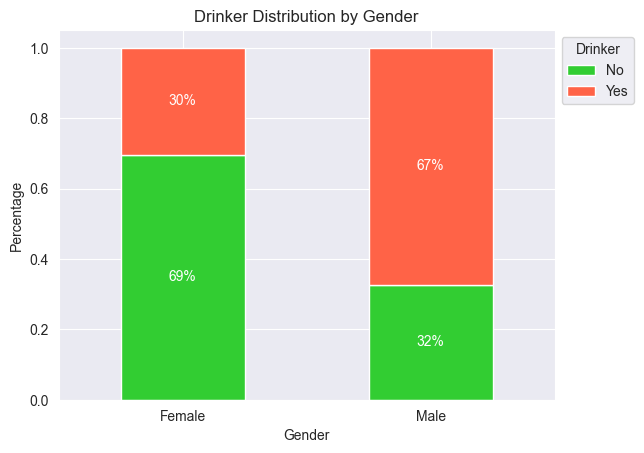

In [ ]:
df_by_drk = df.groupby(['sex', 'DRK_stat_type_cd']).size().unstack(fill_value=0)

df_by_sex_normalized = df_by_drk.div(df_by_drk.sum(axis=1), axis=0)

ax = df_by_sex_normalized.plot(kind='bar', stacked=True, color=['limegreen', 'tomato'])
plt.title('Drinker Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.xticks(rotation=0)

# Reversing the legend order to match the stack order
handles, labels = ax.get_legend_handles_labels()
ax.legend(labels=['No', 'Yes'], title='Drinker', loc='upper left', bbox_to_anchor=(1.0, 1.0))

# Add annotations for percentages
for x, y in enumerate([*df_by_drk.index.values]):
  for (proportion, y_loc) in zip(df_by_sex_normalized.loc[y], df_by_sex_normalized.loc[y].cumsum()):
    ax.text(x=x, y=(y_loc - proportion) + (proportion / 2), s=f'{int(proportion * 100)}%',
      color="white", ha="center", va="center")

plt.show()


In [ ]:
health_columns = ['sex_type_cd', 'age', 'BMI', 'waistline', 'BP_Category', 'BLDS', 'chole_category', 'LDL_chole', 'triglyceride', 'hemoglobin',
          'urine_protein', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'SMK_stat_type_cd', 'DRK_stat_type_cd']


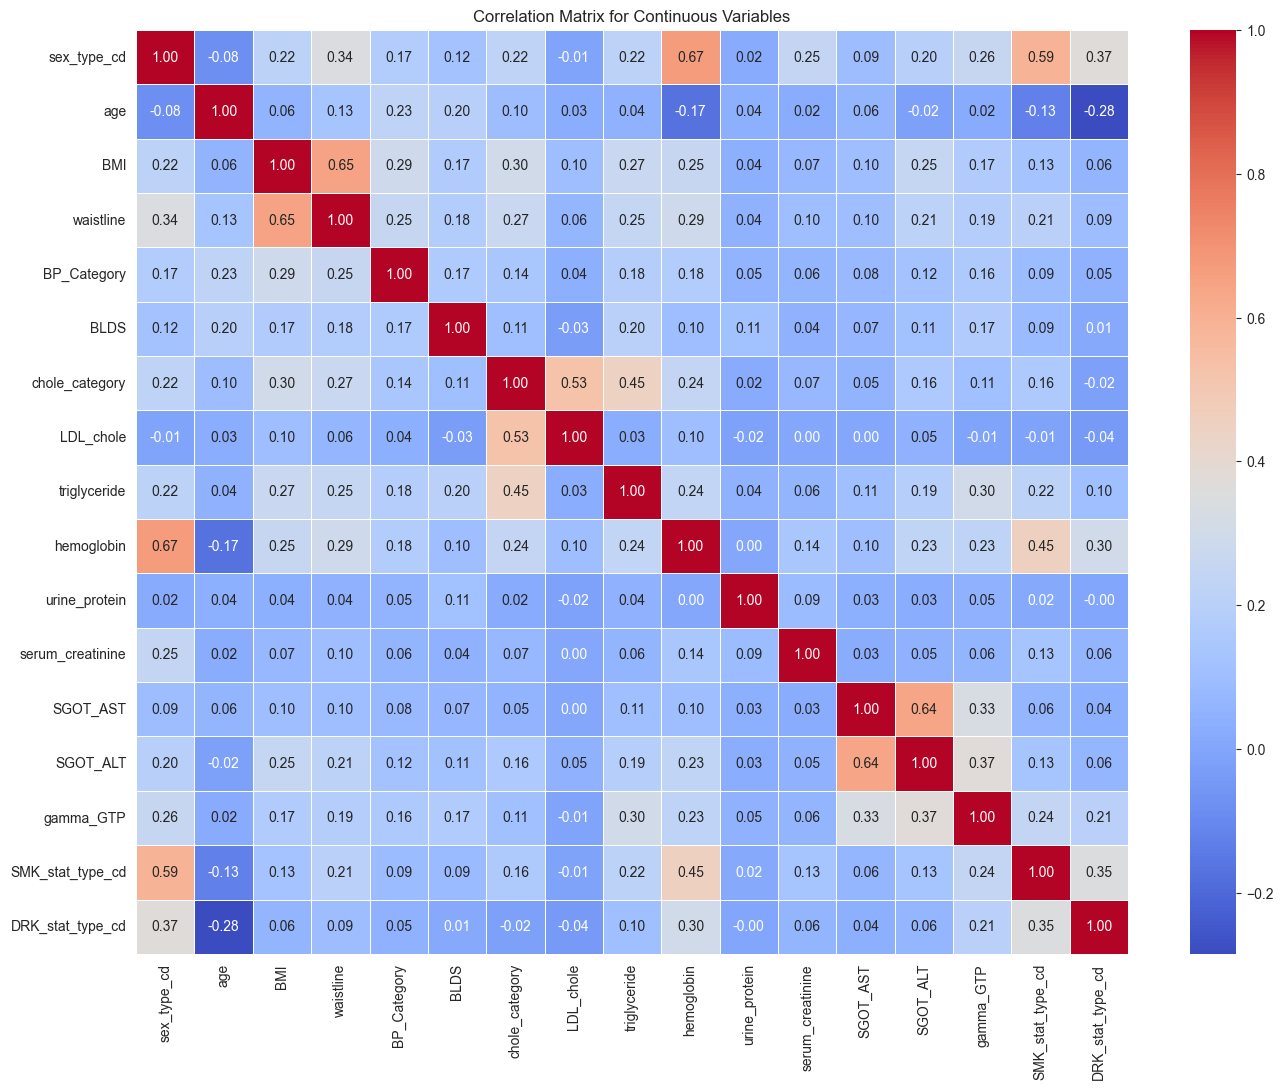

In [ ]:
# Selecting continuous variables for correlation analysis
correlation_matrix = df[health_columns].corr()

# Correlation Matrix Heatmap Visualization
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix for Continuous Variables')
plt.show()


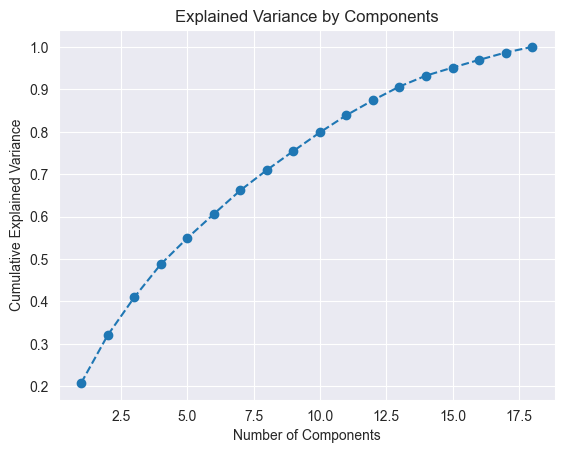

Number of components to explain 90.0% variance: 13


In [ ]:
df['SMK_stat_type_cd_binary'] = df['SMK_stat_type_cd'].apply(lambda stat: 1 if stat in [1, 2] else 0)

pca_columns = ['sex_type_cd', 'age', 'BMI', 'waistline', 'sights_impaired', 'BP_Category', 'BLDS', 'chole_category', 'LDL_chole', 'triglyceride', 'hemoglobin',
          'urine_protein', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'SMK_stat_type_cd_binary', 'DRK_stat_type_cd']

# Standardize the data
X = StandardScaler().fit_transform(df[pca_columns])

# Fit PCA
pca = PCA().fit(X)

# Plot the cumulative sum of explained variance ratio
plt.figure()
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Find the number of components for a given threshold
threshold_variance = 0.90
cumulative_variance = pca.explained_variance_ratio_.cumsum()
n_components = len(cumulative_variance[cumulative_variance <= threshold_variance]) + 1

print(f"Number of components to explain {threshold_variance*100}% variance: {n_components}")


# Advanced Machine Learning Models for Smoking and Drinking Status Prediction


This comprehensive code block is dedicated to building and evaluating machine learning models for predicting smoking and drinking status in a dataset. The block is segmented into various parts, each focusing on different aspects of model building and evaluation.



In [ ]:
def show_confusion_matrix(cm, class_names):
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='g', cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix', weight='bold')
    plt.show()

X_SMK = df[pca_columns].drop('SMK_stat_type_cd_binary', axis=1)
X_SMK_scaled = StandardScaler().fit_transform(X_SMK)
y_SMK = df['SMK_stat_type_cd_binary']

X_DRK = df[pca_columns].drop('DRK_stat_type_cd', axis=1)
X_DRK_scaled = StandardScaler().fit_transform(X_DRK)
y_DRK = df['DRK_stat_type_cd']


In [ ]:
solver_penalty = {
    'liblinear': ['l1', 'l2'],
    'lbfgs': ['l2'],
}

C = [0.01, 0.1, 0.2, 1]

param_grid = [{
    'penalty': penalties,
    'C': C,
    'solver': [solver],
} for solver, penalties in solver_penalty.items()]

logreg_SMK = LogisticRegression(max_iter=10000)
logreg_DRK = LogisticRegression(max_iter=10000)


In [ ]:
grid_logreg_SMK = GridSearchCV(logreg_SMK, param_grid=param_grid, cv=5, verbose=2)
grid_logreg_SMK.fit(X_SMK_scaled, y_SMK)
print(f'The best parameters are {grid_logreg_SMK.best_params_} with a score of {grid_logreg_SMK.best_score_}')

best_logreg_SMK = LogisticRegression(solver=grid_logreg_SMK.best_params_['solver'], penalty=grid_logreg_SMK.best_params_['penalty'], C=grid_logreg_SMK.best_params_['C'], max_iter=10000)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   5.4s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   4.8s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   4.6s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   4.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   4.3s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   4.4s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   4.3s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   4.5s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   4.4s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   4.5s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   4.9s
[CV] END ................C=0.1, penalty=l1, solv

In [ ]:
grid_logreg_DRK = GridSearchCV(logreg_DRK, param_grid=param_grid, cv=5, verbose=2)
grid_logreg_DRK.fit(X_DRK_scaled, y_DRK)
print(f'The best parameters are {grid_logreg_DRK.best_params_} with a score of {grid_logreg_DRK.best_score_}')

best_logreg_DRK = LogisticRegression(solver=grid_logreg_DRK.best_params_['solver'], penalty=grid_logreg_DRK.best_params_['penalty'], C=grid_logreg_DRK.best_params_['C'], max_iter=10000)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   5.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   5.1s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   5.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   4.9s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   4.9s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   4.8s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   5.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   4.9s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   5.2s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   4.9s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   4.7s
[CV] END ................C=0.1, penalty=l1, solv

In [ ]:
y_SMK_pred = cross_val_predict(best_logreg_SMK, X_SMK_scaled, y_SMK, cv=5)
logreg_SMK_accuracy = accuracy_score(y_SMK, y_SMK_pred)
logreg_SMK_f1 = f1_score(y_SMK, y_SMK_pred)

print("Classification Report for Smoking Status:")
print(classification_report(y_SMK, y_SMK_pred, target_names=['Non-Smoker', 'Smoker']))

# Accuracy for each label
print("Accuracy for Smoker prediction:", logreg_SMK_accuracy)
print("F1 score for Smoker prediction:", logreg_SMK_f1)


Classification Report for Smoking Status:
              precision    recall  f1-score   support

  Non-Smoker       0.91      0.76      0.83    602441
      Smoker       0.71      0.88      0.78    388905

    accuracy                           0.81    991346
   macro avg       0.81      0.82      0.81    991346
weighted avg       0.83      0.81      0.81    991346

Accuracy for Smoker prediction: 0.8082516094279898
F1 score for Smoker prediction: 0.781986776233922


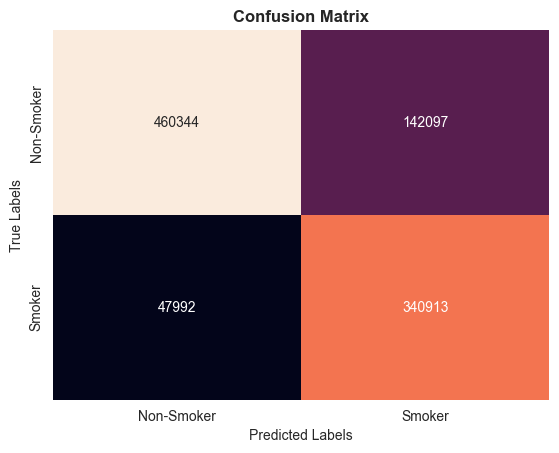

In [ ]:
logreg_conf_matrix_SMK = confusion_matrix(y_SMK, y_SMK_pred)
show_confusion_matrix(logreg_conf_matrix_SMK, ['Non-Smoker', 'Smoker'])


In [ ]:
y_DRK_pred = cross_val_predict(best_logreg_DRK, X_DRK_scaled, y_DRK, cv=5)
logreg_DRK_accuracy = accuracy_score(y_DRK, y_DRK_pred)
logreg_DRK_f1 = f1_score(y_DRK, y_DRK_pred)

print("Classification Report for Drinking Status:")
print(classification_report(y_DRK, y_DRK_pred, target_names=['Non-Drinker', 'Drinker']))

# Accuracy for each label
print("Accuracy for Drinker prediction:", logreg_DRK_accuracy)
print("F1 score for Drinker prediction:", logreg_DRK_f1)


Classification Report for Drinking Status:
              precision    recall  f1-score   support

 Non-Drinker       0.72      0.73      0.72    495858
     Drinker       0.72      0.72      0.72    495488

    accuracy                           0.72    991346
   macro avg       0.72      0.72      0.72    991346
weighted avg       0.72      0.72      0.72    991346

Accuracy for Drinker prediction: 0.7227607717184514
F1 score for Drinker prediction: 0.7216088423935724


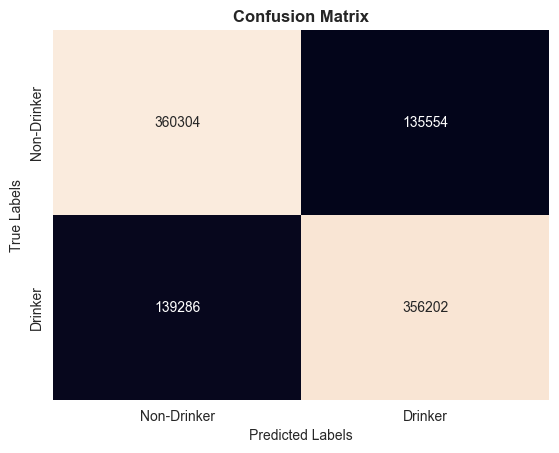

In [ ]:
logreg_conf_matrix_DRK = confusion_matrix(y_DRK, y_DRK_pred)
show_confusion_matrix(logreg_conf_matrix_DRK, ['Non-Drinker', 'Drinker'])


In [ ]:
print("Accuracy for overall prediction:", (logreg_SMK_accuracy + logreg_DRK_accuracy) / 2)
print("Accuracy for overall prediction:", (logreg_SMK_f1 + logreg_DRK_f1) / 2)


Accuracy for overall prediction: 0.7655061905732206
Accuracy for overall prediction: 0.7517978093137472


In [ ]:
xgb_SMK = XGBClassifier(booster='gbtree', eval_metric='logloss', objective='binary:logistic')
xgb_DRK = XGBClassifier(booster='gbtree', eval_metric='logloss', objective='binary:logistic')


In [ ]:
y_SMK_pred = cross_val_predict(xgb_SMK, X_SMK_scaled, y_SMK, cv=5)
xgb_SMK_accuracy = accuracy_score(y_SMK, y_SMK_pred)
xgb_SMK_f1 = f1_score(y_SMK, y_SMK_pred)

print("Classification Report for Smoking Status:")
print(classification_report(y_SMK, y_SMK_pred, target_names=['Non-Smoker', 'Smoker']))

# Accuracy for each label
print("Accuracy for Smoker prediction:", xgb_SMK_accuracy)
print("F1 score for Smoker prediction:", xgb_SMK_f1)


Classification Report for Smoking Status:
              precision    recall  f1-score   support

  Non-Smoker       0.90      0.79      0.84    602441
      Smoker       0.72      0.86      0.78    388905

    accuracy                           0.81    991346
   macro avg       0.81      0.82      0.81    991346
weighted avg       0.83      0.81      0.82    991346

Accuracy for Smoker prediction: 0.8142727160849996
F1 score for Smoker prediction: 0.7839661892771573


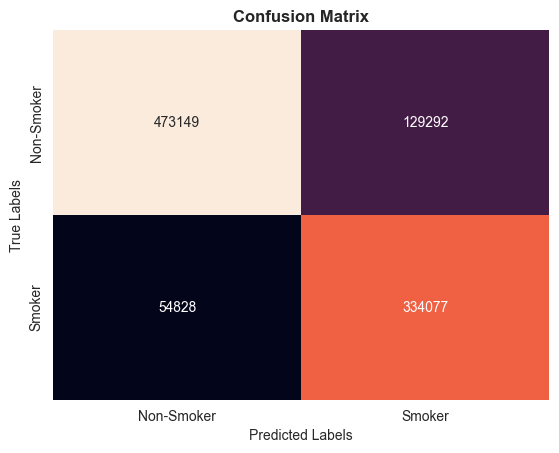

In [ ]:
xgb_conf_matrix_SMK = confusion_matrix(y_SMK, y_SMK_pred)
show_confusion_matrix(xgb_conf_matrix_SMK, ['Non-Smoker', 'Smoker'])


In [ ]:
y_DRK_pred = cross_val_predict(xgb_DRK, X_DRK_scaled, y_DRK, cv=5)
xgb_DRK_accuracy = accuracy_score(y_DRK, y_DRK_pred)
xgb_DRK_f1 = f1_score(y_DRK, y_DRK_pred)

print("Classification Report for Drinking Status:")
print(classification_report(y_DRK, y_DRK_pred, target_names=['Non-Drinker', 'Drinker']))

# Accuracy for each label
print("Accuracy for Drinker prediction:", xgb_DRK_accuracy)
print("F1 score for Drinker prediction:", xgb_DRK_f1)


Classification Report for Drinking Status:
              precision    recall  f1-score   support

 Non-Drinker       0.74      0.73      0.73    495858
     Drinker       0.73      0.74      0.74    495488

    accuracy                           0.74    991346
   macro avg       0.74      0.74      0.74    991346
weighted avg       0.74      0.74      0.74    991346

Accuracy for Drinker prediction: 0.7351984070143017
F1 score for Drinker prediction: 0.7366763298592652


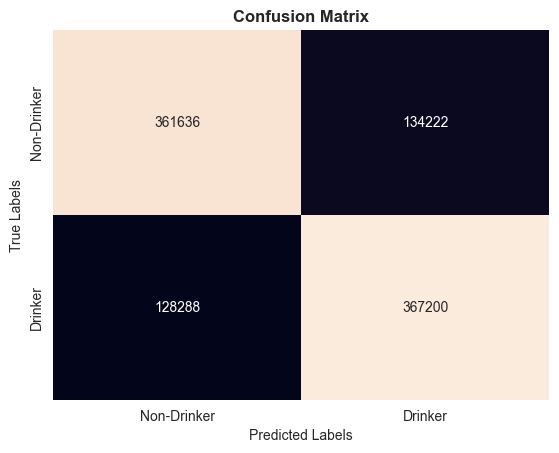

In [ ]:
xgb_conf_matrix_DRK = confusion_matrix(y_DRK, y_DRK_pred)
show_confusion_matrix(xgb_conf_matrix_DRK, ['Non-Drinker', 'Drinker'])


In [ ]:
print("Accuracy for overall prediction:", (xgb_SMK_accuracy + xgb_DRK_accuracy) / 2)
print("Accuracy for overall prediction:", (xgb_SMK_f1 + xgb_DRK_f1) / 2)


Accuracy for overall prediction: 0.7747355615496507
Accuracy for overall prediction: 0.7603212595682113


In [ ]:
xgb_SMK = Pipeline([
    ('scaler', None),
    ('classifier', XGBClassifier(booster='gbtree', eval_metric='logloss', objective='binary:logistic'))
])

xgb_DRK = Pipeline([
    ('scaler', None),
    ('classifier', XGBClassifier(booster='gbtree', eval_metric='logloss', objective='binary:logistic'))
])

param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler()],
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}


In [ ]:
grid_SMK = GridSearchCV(xgb_SMK, param_grid=param_grid, cv=5, verbose=2)
grid_SMK.fit(X_SMK, y_SMK)
print(f'The best parameters are {grid_SMK.best_params_} with a score of {grid_SMK.best_score_}')

scaler_type = type(grid_SMK.best_estimator_.named_steps['scaler'])

if scaler_type is StandardScaler:
    best_scaler = StandardScaler()
else:
    best_scaler = MinMaxScaler()

best_xgb = Pipeline([
    ('scaler', best_scaler),
    ('classifier', XGBClassifier(booster='gbtree', eval_metric='logloss', objective='binary:logistic',
                                 n_estimators=grid_SMK.best_params_['classifier__n_estimators']+100,
                                 learning_rate=grid_SMK.best_params_['classifier__learning_rate'],
                                 subsample=grid_SMK.best_params_['classifier__subsample'],
                                 colsample_bytree=grid_SMK.best_params_['classifier__colsample_bytree']))
])


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__n_estimators=100, classifier__subsample=0.8, scaler=StandardScaler(); total time=   5.4s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__n_estimators=100, classifier__subsample=0.8, scaler=StandardScaler(); total time=   5.2s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__n_estimators=100, classifier__subsample=0.8, scaler=StandardScaler(); total time=   5.3s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__n_estimators=100, classifier__subsample=0.8, scaler=StandardScaler(); total time=   5.2s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__n_estimators=100, classifier__subsample=0.8, scaler=StandardScaler(); total time=   5.3s
[CV] END classifier__colsample_bytree=0.8, classifier__lea

In [ ]:
y_SMK_pred = cross_val_predict(best_xgb, X_SMK, y_SMK, cv=5)
xgb_SMK_accuracy = accuracy_score(y_SMK, y_SMK_pred)
xgb_SMK_f1 = f1_score(y_SMK, y_SMK_pred)

print("Classification Report for Smoking Status:")
print(classification_report(y_SMK, y_SMK_pred, target_names=['Non-Smoker', 'Smoker']))

# Accuracy for each label
print("Accuracy for Smoker prediction:", xgb_SMK_accuracy)
print("F1 score for Smoker prediction:", xgb_SMK_f1)


Classification Report for Smoking Status:
              precision    recall  f1-score   support

  Non-Smoker       0.90      0.78      0.84    602441
      Smoker       0.72      0.86      0.78    388905

    accuracy                           0.81    991346
   macro avg       0.81      0.82      0.81    991346
weighted avg       0.83      0.81      0.82    991346

Accuracy for Smoker prediction: 0.8148557617622909
F1 score for Smoker prediction: 0.7849648055636265


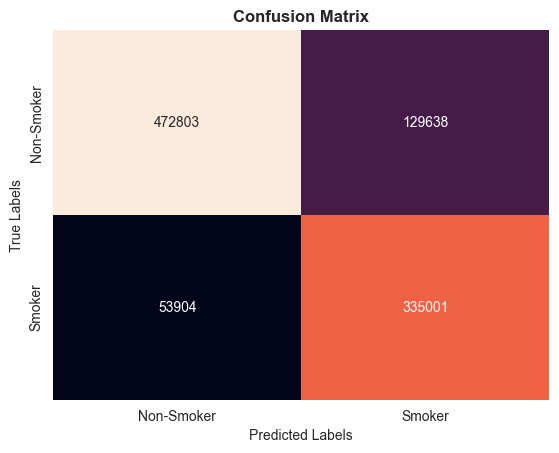

In [ ]:
xgb_conf_matrix_SMK = confusion_matrix(y_SMK, y_SMK_pred)
show_confusion_matrix(xgb_conf_matrix_SMK, ['Non-Smoker', 'Smoker'])


In [ ]:
grid_DRK = GridSearchCV(xgb_DRK, param_grid=param_grid, cv=5, verbose=2)
grid_DRK.fit(X_DRK, y_DRK)
print(f'The best parameters are {grid_DRK.best_params_} with a score of {grid_DRK.best_score_}')

scaler_type = type(grid_DRK.best_estimator_.named_steps['scaler'])

if scaler_type is StandardScaler:
    best_scaler = StandardScaler()
else:
    best_scaler = MinMaxScaler()

best_xgb = Pipeline([
    ('scaler', best_scaler),
    ('classifier', XGBClassifier(booster='gbtree', eval_metric='logloss', objective='binary:logistic',
                                 n_estimators=grid_DRK.best_params_['classifier__n_estimators']+100,
                                 learning_rate=grid_DRK.best_params_['classifier__learning_rate'],
                                 subsample=grid_DRK.best_params_['classifier__subsample'],
                                 colsample_bytree=grid_DRK.best_params_['classifier__colsample_bytree']))
])


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__n_estimators=100, classifier__subsample=0.8, scaler=StandardScaler(); total time=   5.3s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__n_estimators=100, classifier__subsample=0.8, scaler=StandardScaler(); total time=   5.4s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__n_estimators=100, classifier__subsample=0.8, scaler=StandardScaler(); total time=   5.6s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__n_estimators=100, classifier__subsample=0.8, scaler=StandardScaler(); total time=   5.2s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__n_estimators=100, classifier__subsample=0.8, scaler=StandardScaler(); total time=   5.1s
[CV] END classifier__colsample_bytree=0.8, classifier__lea

In [ ]:
y_DRK_pred = cross_val_predict(best_xgb, X_DRK, y_DRK, cv=5)
xgb_DRK_accuracy = accuracy_score(y_DRK, y_DRK_pred)
xgb_DRK_f1 = f1_score(y_DRK, y_DRK_pred)

print("Classification Report for Drinking Status:")
print(classification_report(y_DRK, y_DRK_pred, target_names=['Non-Drinker', 'Drinker']))

# Accuracy for each label
print("Accuracy for Drinker prediction:", xgb_DRK_accuracy)
print("F1 score for Drinker prediction:", xgb_DRK_f1)


Classification Report for Drinking Status:
              precision    recall  f1-score   support

 Non-Drinker       0.74      0.73      0.74    495858
     Drinker       0.73      0.74      0.74    495488

    accuracy                           0.74    991346
   macro avg       0.74      0.74      0.74    991346
weighted avg       0.74      0.74      0.74    991346

Accuracy for Drinker prediction: 0.7367135187916227
F1 score for Drinker prediction: 0.738329974836336


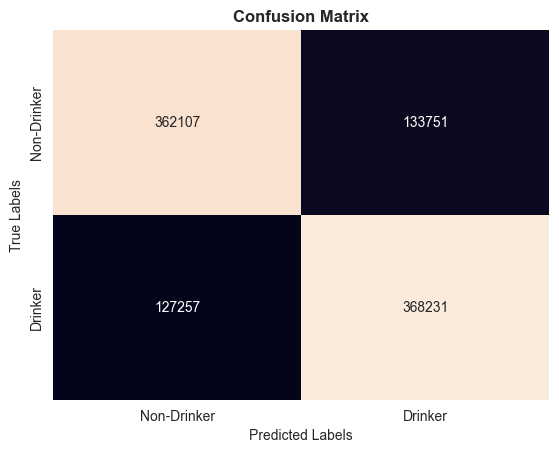

In [ ]:
xgb_conf_matrix_DRK = confusion_matrix(y_DRK, y_DRK_pred)
show_confusion_matrix(xgb_conf_matrix_DRK, ['Non-Drinker', 'Drinker'])


In [ ]:
print("Accuracy for overall prediction:", (xgb_SMK_accuracy + xgb_DRK_accuracy) / 2)
print("F1 score for overall prediction:", (xgb_SMK_f1 + xgb_DRK_f1) / 2)


Accuracy for overall prediction: 0.7757846402769568
F1 score for overall prediction: 0.7616473901999812


In [ ]:
svm_SMK = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(kernel='linear', C=0.001))
])

svm_DRK = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(kernel='linear', C=0.001))
])


In [ ]:
df_sample = df.sample(100000)

X_SMK = df_sample[pca_columns].drop('SMK_stat_type_cd_binary', axis=1)
y_SMK = df_sample['SMK_stat_type_cd_binary']

X_DRK = df_sample[pca_columns].drop('DRK_stat_type_cd', axis=1)
y_DRK = df_sample['DRK_stat_type_cd']


In [ ]:
y_SMK_pred = cross_val_predict(svm_SMK, X_SMK, y_SMK, cv=5)
svm_SMK_accuracy = accuracy_score(y_SMK, y_SMK_pred)
svm_SMK_f1 = f1_score(y_SMK, y_SMK_pred)

print("Classification Report for Smoking Status:")
print(classification_report(y_SMK, y_SMK_pred, target_names=['Non-Smoker', 'Smoker']))

# Accuracy for each label
print("Accuracy for Smoker prediction:", svm_SMK_accuracy)
print("F1 score for Smoker prediction:", svm_SMK_f1)


Classification Report for Smoking Status:
              precision    recall  f1-score   support

  Non-Smoker       0.94      0.73      0.82     60852
      Smoker       0.69      0.93      0.79     39148

    accuracy                           0.81    100000
   macro avg       0.81      0.83      0.81    100000
weighted avg       0.84      0.81      0.81    100000

Accuracy for Smoker prediction: 0.80617
F1 score for Smoker prediction: 0.7899021212482521


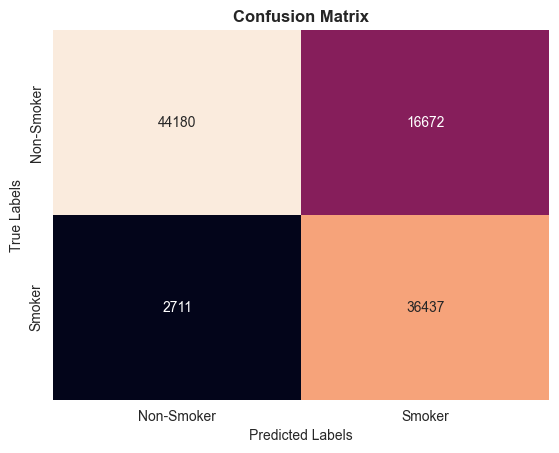

In [ ]:
svm_conf_matrix_SMK = confusion_matrix(y_SMK, y_SMK_pred)
show_confusion_matrix(svm_conf_matrix_SMK, ['Non-Smoker', 'Smoker'])


In [ ]:
y_DRK_pred = cross_val_predict(svm_DRK, X_DRK, y_DRK, cv=5)
svm_DRK_accuracy = accuracy_score(y_DRK, y_DRK_pred)
svm_DRK_f1 = f1_score(y_DRK, y_DRK_pred)

print("Classification Report for Drinking Status:")
print(classification_report(y_DRK, y_DRK_pred, target_names=['Non-Drinker', 'Drinker']))

# Accuracy for each label
print("Accuracy for Drinker prediction:", svm_DRK_accuracy)
print("F1 score for Drinker prediction:", svm_DRK_f1)


Classification Report for Drinking Status:
              precision    recall  f1-score   support

 Non-Drinker       0.71      0.70      0.70     50082
     Drinker       0.70      0.71      0.71     49918

    accuracy                           0.70    100000
   macro avg       0.70      0.70      0.70    100000
weighted avg       0.70      0.70      0.70    100000

Accuracy for Drinker prediction: 0.70416
F1 score for Drinker prediction: 0.7059010656911087


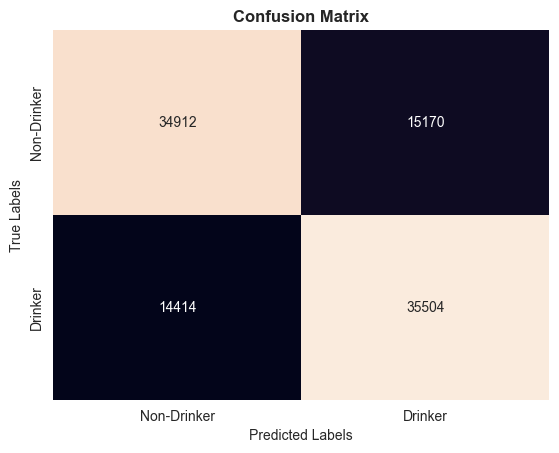

In [ ]:
svm_conf_matrix_DRK = confusion_matrix(y_DRK, y_DRK_pred)
show_confusion_matrix(svm_conf_matrix_DRK, ['Non-Drinker', 'Drinker'])


In [ ]:
print("Accuracy for overall prediction:", (svm_SMK_accuracy + svm_DRK_accuracy) / 2)
print("F1 score for overall prediction:", (svm_SMK_f1 + svm_DRK_f1) / 2)


Accuracy for overall prediction: 0.7551650000000001
F1 score for overall prediction: 0.7479015934696804


In [ ]:
# svm_SMK = Pipeline([
#     ('scaler', None),
#     ('classifier', SVC(probability=True))
# ])

# svm_DRK = Pipeline([
#     ('scaler', None),
#     ('classifier', SVC(probability=True))
# ])

# param_grid = [
#     {
#         'scaler': [StandardScaler(), MinMaxScaler()],
#         'classifier__C': [0.001, 0.01, 0.1, 1.0, 5.0],
#         'classifier__kernel': ['linear']
#     },
#     {
#         'classifier__C': [0.001, 0.01, 0.1, 1.0, 5.0],
#         'classifier__gamma': [0.001, 0.01, 0.1, 1.0, 'scale', 'auto'],
#         'classifier__kernel': ['rbf']
#     }
# ]


In [ ]:
# grid_SMK = GridSearchCV(svm_SMK, param_grid=param_grid, cv=5, verbose=2)
# grid_SMK.fit(X_SMK, y_SMK)
# print(f'The best parameters are {grid_SMK.best_params_} with a score of {grid_SMK.best_score_}')

# scaler_type = type(grid_SMK.best_estimator_.named_steps['scaler'])

# if scaler_type is StandardScaler:
#     best_scaler = StandardScaler()
# else:
#     best_scaler = MinMaxScaler()

# if grid_SMK.best_params_['classifier__estimator__kernel'] == 'rbf':
#     best_svm = SVC(kernel='rbf',
#                    C=grid_SMK.best_params_['classifier__C'],
#                    gamma=grid_SMK.best_params_['classifier__gamma'],
#                    probability=True)
# else:
#     best_svm = SVC(kernel='linear',
#                    C=grid_SMK.best_params_['classifier__C'],
#                    probability=True)


In [ ]:
# # Predictions and evaluation
# y_pred_SMK = cross_val_predict(best_svm, X_SMK, y_SMK, cv=5)
# svc_accuracy_SMK = accuracy_score(y_SMK, y_pred_SMK)

# print("Classification Report for Drinking Status:")
# print(classification_report(y_SMK, y_pred_SMK, target_names=['Non-Smoker', 'Smoker']))

# # Accuracy for each label
# print("Accuracy for Drinker prediction:", svc_accuracy_SMK)


In [ ]:
# grid_DRK = GridSearchCV(svm_DRK, param_grid=param_grid, cv=5, verbose=2)
# grid_DRK.fit(X_DRK, y_DRK)
# print(f'The best parameters are {grid_DRK.best_params_} with a score of {grid_DRK.best_score_}')

# scaler_type = type(grid_DRK.best_estimator_.named_steps['scaler'])

# if scaler_type is StandardScaler:
#     best_scaler = StandardScaler()
# else:
#     best_scaler = MinMaxScaler()

# if grid_DRK.best_params_['classifier__estimator__kernel'] == 'rbf':
#     best_svm = SVC(kernel='rbf',
#                    C=grid_DRK.best_params_['classifier__C'],
#                    gamma=grid_DRK.best_params_['classifier__gamma'],
#                    probability=True)
# else:
#     best_svm = SVC(kernel='linear',
#                    C=grid_DRK.best_params_['classifier__C'],
#                    probability=True)


In [ ]:
# # Predictions and evaluation
# y_pred_DRK = cross_val_predict(best_svm, X_DRK, y_DRK, cv=5)
# svc_accuracy_DRK = accuracy_score(y_DRK, y_pred_DRK)

# print("Classification Report for Drinking Status:")
# print(classification_report(y_DRK, y_pred_DRK, target_names=['Non-Drinker', 'Drinker']))

# # Accuracy for each label
# print("Accuracy for Drinker prediction:", svc_accuracy_DRK)
